In [4]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint

In [80]:
# from paper

x_l = 1.5          # meter (length of large intestine is 1.5 meter)
x_s = 3.5          # meter  (5 - 1.5 = 3.5 length of small intestine)
r_s = 1.25         # centimeter
r_l = 2.5          # centimeter
a_s = 0.65         # constant
a_l = 1.0          # constant
Q_s = 3            # mL/min
Q_l = 5            # mL/min
m   = 100          # milligram (dose)

# patient weight
w  = 70            # Kg
Vd = 1    # ranges (0.8–1.2)  # L / kg

# find flow velocity
v_s = Q_s / (np.pi * r_s**2)  # 
v_l = Q_l / (np.pi * r_l**2)  # 

# define carbamazepine drug spread out time scale tou
max_con = 0.5          #
tou     = 20           # hrs  

# value to ka and ke which depends upon patients
ka = 0.5               # constant
ke = np.log(2) / 20     # constant

In [81]:
# Define saw tooth funnction
def drug_spread_out(t, x):
    t = t - x

    if (t >= 0) and (t < tou /2):
        return (2 / tou**2)*t
    
    elif ((tou/2) < t) and (t < tou):
        return (2 / tou**2)*(tou - t)
    
    else:
        return 0
    
# solving equation for small_intestine
def small_intestine(t, ka):
    x = (x_s / v_s)
    J = m*drug_spread_out(t, x)
    
    return ka*(J*x_s*np.exp(-x_s*a_s/v_s*ka))

# solving equation for large intestine
def large_intestine(t, ka):
    x = ((x_l - x_s) * np.pi**2 * r_l**2) / Q_l
    J = m*drug_spread_out(t, x)
    
    return ka*(J*(x_l - x_s)*np.exp(-(x_l - x_s)*a_l/v_l*ka))

# define ordinary differential equation
def model(b, t):
    A_t  =  small_intestine(t, ka) + large_intestine(t, ka)
    dbdt = 1 / (w * Vd) * (A_t) - ke*b
    
    return dbdt
    
    
    

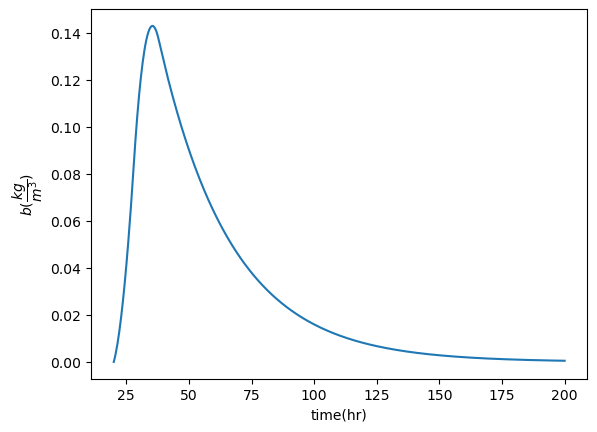

In [83]:
b = 0
t = np.linspace(20, 200, 500)

# solve the ODE equation
sol = odeint(model, b, t)

# plot results
plt.plot(t, sol)
plt.xlabel('time(hr)')
plt.ylabel('$b(\dfrac{kg}{m^{3}})$')
plt.show()

Working on Sawtooth wave which repeats after 24 hrs

In [84]:
#perioid after 24 hrs
pd_time = 24
def find_sawtooth_wave(x, t):
#     J = 0
    pd_ind = int(t // pd_time)
    t      = t - pd_ind * pd_time
    J      = m*drug_spread_out(t, x)
    return J

In [85]:
doeses  = [100, 100]
pd_time = 24

# solving equation for small_intestine
def small_intestine(t, ka):
    x = (x_s * np.pi**2 * r_s**2) / Q_s
    J = find_sawtooth_wave(x, t)
    
    return ka*(J*x_s*np.exp(-x_s*a_s/v_s*ka))

# solving equation for large intestine
def large_intestine(t, ka):
    x = ((x_l - x_s) * np.pi**2 * r_l**2) / Q_l
    J = find_sawtooth_wave(x, t)
    
    return ka*(J*(x_l - x_s)*np.exp(-(x_l - x_s)*a_l/v_l*ka))

# define ordinary differential equation
def model(b, t):
    A_t  =  small_intestine(t, ka) + large_intestine(t, ka)
    dbdt = 1 / (w * Vd) * (A_t) - ke*b
    
    return dbdt

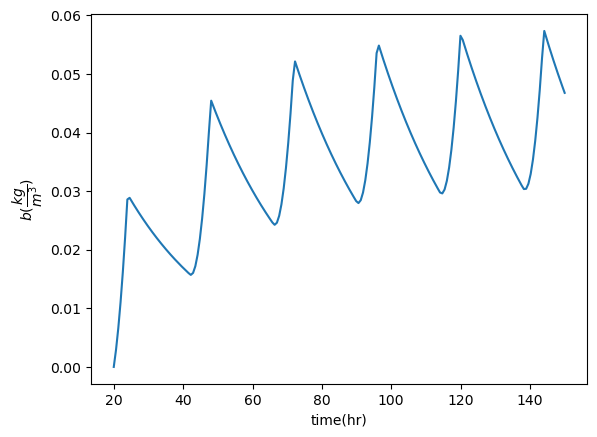

In [86]:
%matplotlib inline
b = 0
t = np.linspace(20, 150, 200)

# solve the ODE equation
sol = odeint(model, b, t)

# plot results
plt.plot(t, sol)
plt.xlabel('time(hr)')
plt.ylabel('$b(\dfrac{kg}{m^{3}})$')
plt.show()

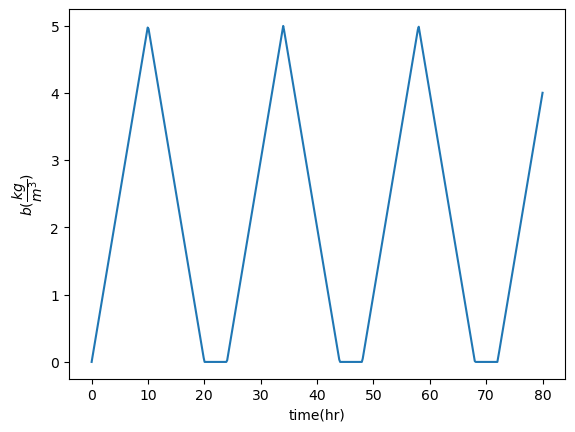

In [75]:
#perioid after 24 hrs

# def find_sawtooth_wave(x, t):
#     J = 0
#     for pd, m in enumerate(doeses):
#         t = t - pd * pd_time
#         print('t', t)
#         J += m*drug_spread_out(t, x)
#     return J

t = np.linspace(0, 80, 500)
x = 0

# x = 0
sol = [find_sawtooth_wave(x, i) for i in t]

# plot results
plt.plot(t, sol)
plt.xlabel('time(hr)')
plt.ylabel('$b(\dfrac{kg}{m^{3}})$')
plt.show()
